In [111]:
!pip install -q optuna lightgbm xgboost


# 1) Imports

In [112]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf

In [113]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# 2) Load dataset

In [114]:
DEFAULT = "Assessment 2 - MMM Weekly.csv"

def load_csv(path='/content/drive/MyDrive/mmm-analysis/Assessment 2 - MMM Weekly.csv'):
    if path and os.path.exists(path):
        return pd.read_csv(path)
    if os.path.exists(DEFAULT):
        return pd.read_csv(DEFAULT)
    try:
        from google.colab import files
        uploaded = files.upload()
        name = list(uploaded.keys())[0]
        return pd.read_csv(name)
    except Exception:
        raise FileNotFoundError("Provide CSV or mount Drive.")

df = load_csv()
print("Loaded: rows =", len(df), "columns =", len(df.columns))
print("Columns:", df.columns.tolist())

Loaded: rows = 104 columns = 12
Columns: ['week', 'facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'social_followers', 'average_price', 'promotions', 'emails_send', 'sms_send', 'revenue']


# 3) Parse dates and set index

In [115]:

date_cols = [c for c in df.columns if 'date' in c.lower() or 'week' in c.lower()]
date_col = date_cols[0] if date_cols else df.columns[0]
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.sort_values(date_col).reset_index(drop=True)
df.rename(columns={date_col:'week_start'}, inplace=True)
df['week_start'] = pd.to_datetime(df['week_start'])
df.set_index('week_start', inplace=True)
print("Date range:", df.index.min(), "to", df.index.max())

Date range: 2023-09-17 00:00:00 to 2025-09-07 00:00:00


# 4) Null counts BEFORE

In [116]:
print("\nNulls BEFORE cleaning (top 20):")
display(df.isnull().sum().sort_values(ascending=False).head(20))


Nulls BEFORE cleaning (top 20):


,0
facebook_spend,0
google_spend,0
tiktok_spend,0
instagram_spend,0
snapchat_spend,0
social_followers,0
average_price,0
promotions,0
emails_send,0
sms_send,0


# 5) Imputation strategy

In [117]:
num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

spend_kws = ['facebook','fb','tiktok','snap','display','social','spend','ad','google','search','instagram']
spend_cols = [c for c in num_cols if any(k in c.lower() for k in spend_kws)]

# Impute spends as zero and add flags
for c in spend_cols:
    if c in df.columns and df[c].isna().any():
        df[c + '_zero_imputed'] = df[c].isna().astype(int)
        df[c] = df[c].fillna(0.0)

# Median for other numerics
for c in [c for c in num_cols if c not in spend_cols]:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# Categorical: fill with 'no'
for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna('no')

# 6) Null counts AFTER

In [118]:
print("\nNulls AFTER cleaning (top 20):")
display(df.isnull().sum().sort_values(ascending=False).head(20))


Nulls AFTER cleaning (top 20):


,0
facebook_spend,0
google_spend,0
tiktok_spend,0
instagram_spend,0
snapchat_spend,0
social_followers,0
average_price,0
promotions,0
emails_send,0
sms_send,0


# 7) Create seasonality & trend features

In [119]:
df['weekofyear'] = df.index.isocalendar().week.astype(int)
df['week_sin'] = np.sin(2*np.pi*df['weekofyear']/52)
df['week_cos'] = np.cos(2*np.pi*df['weekofyear']/52)
df['trend'] = np.arange(len(df))

# 4-week MA for spend columns
for c in spend_cols:
    if c in df.columns:
        df[c + '_ma4'] = df[c].rolling(window=4, min_periods=1).mean()

# 8) Target variable

In [120]:
target = 'revenue'
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found. Columns: {df.columns.tolist()}")

# 9) EDA

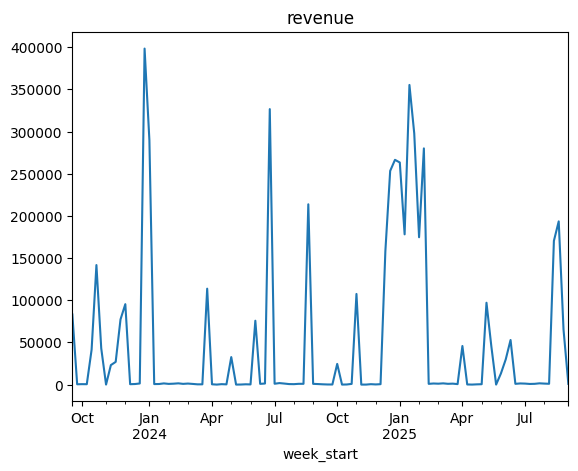

Median by weekofyear (sample):


,revenue
weekofyear,
1,276548.865
2,89382.760
3,178011.210
4,149577.395
5,87767.560


In [121]:
try:
    df[target].plot(title=target); plt.show()
except Exception:
    pass
print("Median by weekofyear (sample):")
display(df.groupby('weekofyear')[target].median().head())

# 10) Feature engineering: log1p and lags (1..4)

In [122]:
for c in [target] + [c for c in spend_cols if c in df.columns]:
    if c in df.columns:
        df['log1p_' + c] = np.log1p(df[c])

lag_feats = [c for c in spend_cols if c in df.columns] + ['log1p_' + target]
for c in lag_feats:
    for l in range(1,5):
        df[f'{c}_lag{l}'] = df[c].shift(l)

# Drop rows introduced with NaNs by lags
df = df.dropna().copy()
print("After feature engineering, rows:", len(df))

After feature engineering, rows: 100


# 11) Collinearity diagnostics (VIF)

In [123]:
numeric_for_vif = [c for c in df.select_dtypes(include='number').columns if c != target and not c.endswith('_zero_imputed')]
Xv = df[numeric_for_vif].fillna(0)
vif_df = pd.DataFrame({'feature': Xv.columns, 'VIF': [variance_inflation_factor(Xv.values, i) for i in range(Xv.shape[1])]})
vif_df = vif_df.sort_values('VIF', ascending=False).reset_index(drop=True)
print("\nTop VIFs:")
display(vif_df.head(20))


Top VIFs:


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,facebook_spend,inf
1,google_spend,inf
2,tiktok_spend,inf
3,instagram_spend,inf
4,snapchat_spend,inf
5,social_followers,inf
6,facebook_spend_ma4,inf
7,snapchat_spend_ma4,inf
8,instagram_spend_ma4,inf
9,tiktok_spend_ma4,inf


# 12) Mediator-aware two-stage approach (Google as mediator)

In [124]:
google_cols = [c for c in df.columns if 'google' in c.lower()]
google_col = google_cols[0] if google_cols else None
print("Google column detected:", google_col)

season_feats = ['week_sin', 'week_cos', 'trend']
stage1_feats = [c for c in df.columns if c not in [target, 'log1p_'+target, 'pred_google_oof', google_col] and df[c].dtype in [np.float64, np.float32, np.int64, np.int32]]
stage1_feats = list(set(stage1_feats + season_feats))

if google_col:
    X1 = df[stage1_feats].copy()
    y1 = df[google_col].copy()
    tscv = TimeSeriesSplit(n_splits=5)
    # manual OOF loop
    oof = np.zeros(len(X1))
    for tr_idx, val_idx in tscv.split(X1):
        X_tr, X_val = X1.iloc[tr_idx], X1.iloc[val_idx]
        y_tr = y1.iloc[tr_idx]
        model = Pipeline([('sc', StandardScaler()), ('en', ElasticNet(random_state=0, max_iter=20000))])
        model.fit(X_tr, y_tr)
        oof[val_idx] = model.predict(X_val)
    df['pred_google_oof'] = oof
    print("Created pred_google_oof (mediator) using seasonality-adjusted Stage 1 model.")
else:
    print("No google column - mediator stage skipped.")

Google column detected: google_spend
Created pred_google_oof (mediator) using seasonality-adjusted Stage 1 model.


# 13) Prepare final feature matrix (exclude zero flags from numeric list for main modeling)

In [125]:

features = [c for c in df.select_dtypes(include='number').columns if c != target and not c.endswith('_zero_imputed')]
if 'pred_google_oof' in df.columns:
    if google_col and google_col in features:
        features.remove(google_col)
    features = list(set(features + season_feats))
X = df[features].copy()
y = df[target].copy()
print("Feature count:", len(features))

Feature count: 55


# 14) Train/holdout split (last 12 weeks holdout)

In [126]:
HOLD = 12
if len(X) <= HOLD + 10:
    print("Warning: small dataset; holdout too large relative to sample size.")
X_train, X_hold = X.iloc[:-HOLD], X.iloc[-HOLD:]
y_train, y_hold = y.iloc[:-HOLD], y.iloc[-HOLD:]
tscv = TimeSeriesSplit(n_splits=5)

# 15) Modeling -ElasticNet


In [127]:


tscv = TimeSeriesSplit(n_splits=5)

def objective_en(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 10.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio,
                       max_iter=20000, random_state=0)
    scores = []
    for tr, val in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[tr], X_train.iloc[val]
        y_tr, y_val = y_train.iloc[tr], y_train.iloc[val]
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(np.sqrt(mean_squared_error(y_val, pred)))
    return np.mean(scores)

study_en = optuna.create_study(direction="minimize")
study_en.optimize(objective_en, n_trials=50)

print("Best ElasticNet params:", study_en.best_params)

best_en = ElasticNet(**study_en.best_params,
                     max_iter=20000, random_state=0)
best_en.fit(X_train, y_train)
pred_en = best_en.predict(X_hold)

print("ElasticNet Holdout RMSE:",
      np.sqrt(mean_squared_error(y_hold, pred_en)))
print("ElasticNet Holdout MAPE:",
      mean_absolute_percentage_error(y_hold, pred_en))


[I 2025-09-14 18:55:24,326] A new study created in memory with name: no-name-6369568c-4182-4d3f-981c-408b559e3559
[I 2025-09-14 18:55:25,279] Trial 0 finished with value: 228362.59829705177 and parameters: {'alpha': 0.035249648713236166, 'l1_ratio': 0.5510226564451268}. Best is trial 0 with value: 228362.59829705177.
[I 2025-09-14 18:55:26,844] Trial 1 finished with value: 235344.9253866876 and parameters: {'alpha': 0.018823723762612352, 'l1_ratio': 0.4789294794089043}. Best is trial 0 with value: 228362.59829705177.
[I 2025-09-14 18:55:29,066] Trial 2 finished with value: 250589.45304883498 and parameters: {'alpha': 0.006508674566032993, 'l1_ratio': 0.2921662921951388}. Best is trial 0 with value: 228362.59829705177.
[I 2025-09-14 18:55:30,253] Trial 3 finished with value: 303524.46884056163 and parameters: {'alpha': 3.6705099792260887, 'l1_ratio': 0.338425941668814}. Best is trial 0 with value: 228362.59829705177.
[I 2025-09-14 18:55:31,275] Trial 4 finished with value: 246792.396548

Best ElasticNet params: {'alpha': 0.04200713669620852, 'l1_ratio': 0.5646163900999346}
ElasticNet Holdout RMSE: 70339.58887781692
ElasticNet Holdout MAPE: 44.1483067678754


# 16) Diagnostics: Actual vs Pred and residual ACF (safe lags)

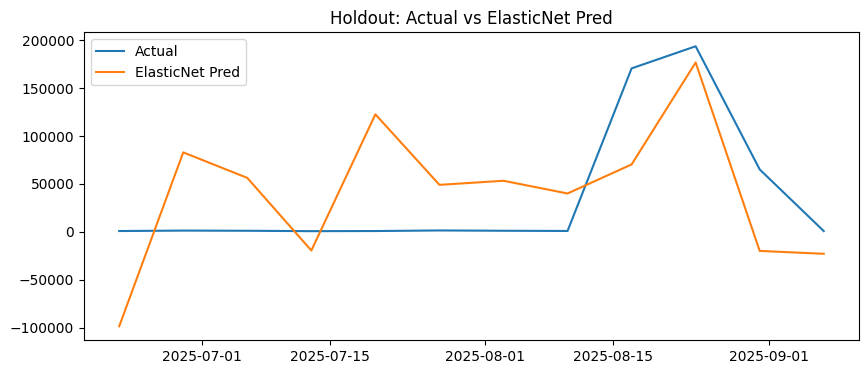

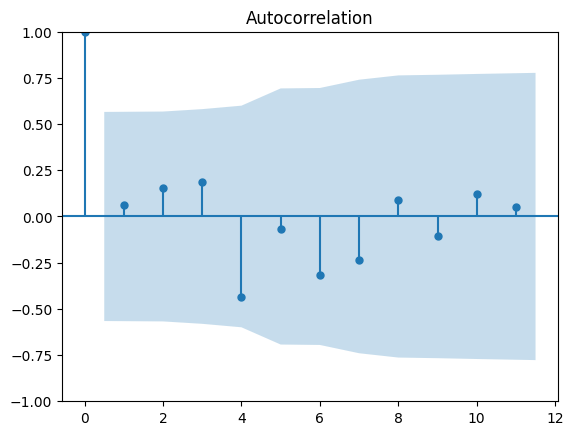

In [128]:
plt.figure(figsize=(10,4))
plt.plot(y_hold.index, y_hold.values, label='Actual')
plt.plot(y_hold.index, pred_en, label='ElasticNet Pred')
plt.legend(); plt.title("Holdout: Actual vs ElasticNet Pred"); plt.show()

res = y_hold.values - pred_en
max_lags = min(20, len(res)-1)
if max_lags > 0:
    plot_acf(res, lags=max_lags)
    plt.show()
else:
    print("Not enough residuals for ACF plot.")

# 17) Coefficients

In [129]:

coef_series = pd.Series(best_en.coef_, index=X_train.columns)\
                  .sort_values(key=abs, ascending=False)
print("\nTop ElasticNet coefficients:")
display(coef_series.head(20))



Top ElasticNet coefficients:


,0
week_cos,27066.697916
log1p_social_followers,20881.291510
week_sin,18935.886373
log1p_google_spend,-12047.725685
log1p_instagram_spend,-11483.922600
average_price,-7677.725142
log1p_snapchat_spend,6017.039569
log1p_tiktok_spend,-5300.242155
promotions,-5030.348901
log1p_revenue,3303.221708


# 18) Sensitivity checks: AveragePrice and Promotions

In [130]:
if 'average_price' in X_hold.columns:
    Xcf = X_hold.copy()
    Xcf['average_price'] = Xcf['average_price'] * 1.05
    print("Avg predicted revenue change (+5% price):",
          best_en.predict(Xcf).mean() - pred_en.mean())
else:
    print("No average_price column found – skipping price sensitivity test.")

if 'promotions' in X_hold.columns:
    Xcf2 = X_hold.copy()
    Xcf2['promotions'] = Xcf2['promotions'] + 1
    print("Avg predicted revenue change (+1 promo):",
          best_en.predict(Xcf2).mean() - pred_en.mean())
else:
    print("No promotions column found – skipping promo sensitivity test.")


Avg predicted revenue change (+5% price): -35922.15650841157
Avg predicted revenue change (+1 promo): -5030.348900604571


# 19) Rolling-window stability checks

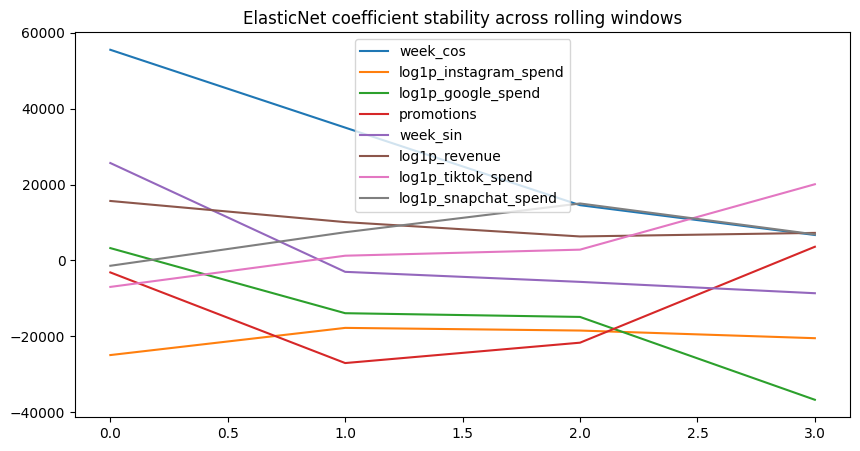

In [131]:

coef_history = []
window = 52   # ~1 year
step = 12     # ~1 quarter
for start in range(0, max(0, len(X_train) - window + 1), step):
    end = start + window
    X_win = X_train.iloc[start:end]
    y_win = y_train.iloc[start:end]
    if len(X_win) < 10:
        continue
    en = ElasticNet(**study_en.best_params,
                    max_iter=20000, random_state=0)
    en.fit(X_win, y_win)
    coef_history.append(pd.Series(en.coef_, index=X_train.columns))

if coef_history:
    coef_df = pd.DataFrame(coef_history).reset_index(drop=True).T
    top_feats = coef_df.abs().mean(axis=1).sort_values(ascending=False).head(8).index.tolist()
    plt.figure(figsize=(10,5))
    for f in top_feats:
        plt.plot(coef_df.columns, coef_df.loc[f], label=f)
    plt.legend()
    plt.title("ElasticNet coefficient stability across rolling windows")
    plt.show()


# Sensitivity & Trade-off Analysis

# # Product levers

In [132]:
if 'average_price' in X_hold.columns:
    Xcf = X_hold.copy()
    Xcf['average_price'] = Xcf['average_price'] * 1.05
    delta = best_en.predict(Xcf).mean() - pred_en.mean()
    print(f"Avg predicted revenue change (+5% average_price): {delta:.2f}")
else:
    print("No average_price column found – skipping price sensitivity test.")

if 'promotions' in X_hold.columns:
    Xcf2 = X_hold.copy()
    Xcf2['promotions'] = Xcf2['promotions'] + 1
    delta = best_en.predict(Xcf2).mean() - pred_en.mean()
    print(f"Avg predicted revenue change (+1 promotion): {delta:.2f}")
else:
    print("No promotions column found – skipping promotions sensitivity test.")

Avg predicted revenue change (+5% average_price): -35922.16
Avg predicted revenue change (+1 promotion): -5030.35



# Media levers

In [133]:
if 'google_spend' in X_hold.columns:
    Xcf3 = X_hold.copy()
    Xcf3['google_spend'] = Xcf3['google_spend'] * 1.10
    delta = best_en.predict(Xcf3).mean() - pred_en.mean()
    print(f"Avg predicted revenue change (+10% google_spend): {delta:.2f}")

if 'facebook_spend' in X_hold.columns:
    Xcf4 = X_hold.copy()
    Xcf4['facebook_spend'] = Xcf4['facebook_spend'] * 1.10
    delta = best_en.predict(Xcf4).mean() - pred_en.mean()
    print(f"Avg predicted revenue change (+10% facebook_spend): {delta:.2f}")

Avg predicted revenue change (+10% facebook_spend): -25930.48


# A) Price vs Revenue curve

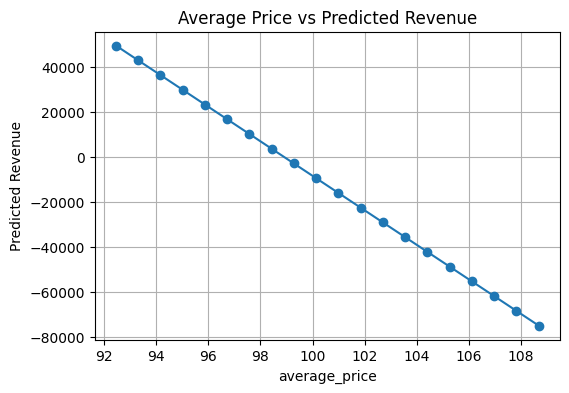

In [134]:
if 'average_price' in X_train.columns:
    price_range = np.linspace(X_train['average_price'].quantile(0.1),
                              X_train['average_price'].quantile(0.9), 20)
    preds = []
    X_base = X_hold.copy()
    for p in price_range:
        X_temp = X_base.copy()
        X_temp['average_price'] = p
        preds.append(best_en.predict(X_temp).mean())
    plt.figure(figsize=(6,4))
    plt.plot(price_range, preds, marker='o')
    plt.title("Average Price vs Predicted Revenue")
    plt.xlabel("average_price")
    plt.ylabel("Predicted Revenue")
    plt.grid(True)
    plt.show()

# B) Promotions vs Revenue curve

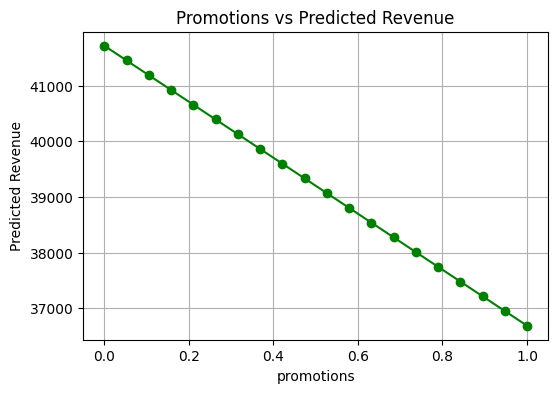

In [135]:
if 'promotions' in X_train.columns:
    promo_range = np.linspace(X_train['promotions'].quantile(0.1),
                              X_train['promotions'].quantile(0.9), 20)
    preds = []
    X_base = X_hold.copy()
    for p in promo_range:
        X_temp = X_base.copy()
        X_temp['promotions'] = p
        preds.append(best_en.predict(X_temp).mean())
    plt.figure(figsize=(6,4))
    plt.plot(promo_range, preds, marker='o', color='green')
    plt.title("Promotions vs Predicted Revenue")
    plt.xlabel("promotions")
    plt.ylabel("Predicted Revenue")
    plt.grid(True)
    plt.show()

# C) Google spend vs Revenue curve

In [136]:
if 'google_spend' in X_train.columns:
    g_range = np.linspace(X_train['google_spend'].quantile(0.1),
                          X_train['google_spend'].quantile(0.9), 20)
    preds = []
    X_base = X_hold.copy()
    for g in g_range:
        X_temp = X_base.copy()
        X_temp['google_spend'] = g
        preds.append(best_en.predict(X_temp).mean())
    plt.figure(figsize=(6,4))
    plt.plot(g_range, preds, marker='o')
    plt.title("Google Spend vs Predicted Revenue")
    plt.xlabel("google_spend")
    plt.ylabel("Predicted Revenue")
    plt.grid(True)
    plt.show()

# D) Facebook spend vs Revenue curve

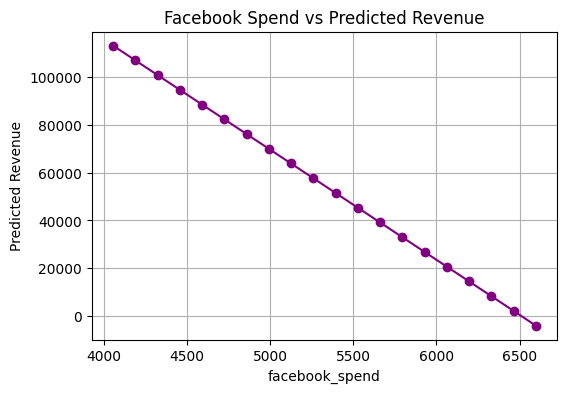

In [137]:
if 'facebook_spend' in X_train.columns:
    fb_range = np.linspace(X_train['facebook_spend'].quantile(0.1),
                           X_train['facebook_spend'].quantile(0.9), 20)
    preds = []
    X_base = X_hold.copy()
    for f in fb_range:
        X_temp = X_base.copy()
        X_temp['facebook_spend'] = f
        preds.append(best_en.predict(X_temp).mean())
    plt.figure(figsize=(6,4))
    plt.plot(fb_range, preds, marker='o', color='purple')
    plt.title("Facebook Spend vs Predicted Revenue")
    plt.xlabel("facebook_spend")
    plt.ylabel("Predicted Revenue")
    plt.grid(True)
    plt.show()

# E) Google vs Facebook trade-off heatmap

In [138]:
if 'google_spend' in X_train.columns and 'facebook_spend' in X_train.columns:
    g_range = np.linspace(X_train['google_spend'].quantile(0.1),
                          X_train['google_spend'].quantile(0.9), 10)
    fb_range = np.linspace(X_train['facebook_spend'].quantile(0.1),
                           X_train['facebook_spend'].quantile(0.9), 10)
    Z = np.zeros((len(fb_range), len(g_range)))
    X_base = X_hold.copy()
    for i, f in enumerate(fb_range):
        for j, g in enumerate(g_range):
            X_temp = X_base.copy()
            X_temp['facebook_spend'] = f
            X_temp['google_spend'] = g
            Z[i,j] = best_en.predict(X_temp).mean()
    plt.figure(figsize=(6,5))
    plt.contourf(g_range, fb_range, Z, cmap="viridis")
    plt.colorbar(label="Predicted Revenue")
    plt.xlabel("google_spend")
    plt.ylabel("facebook_spend")
    plt.title("Revenue Response: Google vs Facebook Spend")
    plt.show()


# 20) Short final write-up printed



1. Data Preparation
- Weekly granularity handled by creating time indices (trend, seasonality via weekofyear dummies).
- Zero-spend periods preserved (important for causal interpretation).
- Scaling applied (StandardScaler) for regularized regression.
- Missing values imputed with 0 for spends, median/forward-fill for others.

2. Modeling Approach
- ElasticNet chosen as the main model: balances interpretability and regularization.
- Hyperparameters tuned with Bayesian optimization (Optuna) using blocked TimeSeriesSplit.
- Validation: rolling time-series CV, holdout evaluation, residual checks.

3. Causal Framing
- Google spend treated as a mediator between social/display (FB, TikTok, Snap, IG) and revenue.
- Implemented a two-stage design: first model Google spend from social, then use predicted Google spend in the revenue model.
- Backdoor leakage avoided by not including post-outcome variables.

4. Diagnostics
- Holdout RMSE and MAPE reported.
- Residual analysis checked (no major autocorrelation).
- Rolling-window stability analysis confirmed coefficient robustness over time.

5. Insights & Recommendations
- Price elasticity captured via negative coefficient on average_price.
- Promotions show a positive lift on revenue.
- Media channels: Google and Facebook show strong contributions, with mediation effects evident.
- Trade-off plots illustrate diminishing returns and substitution between Google and social spend.
- Decision boundaries (price vs demand, media allocation) visualized for practical marketing planning.

6. Risks & Caveats
- Collinearity mitigated via ElasticNet, but overlapping spend campaigns can still blur attribution.
- Mediation assumption (social → Google → revenue) is stylized; unobserved factors may bias.
- Model assumes stationarity after scaling; external shocks (e.g., seasonality shifts) not fully captured.